# Practice Session 05: PageRank

*Introduction to Network Science* (2025/26), UPF

We will compute PageRank on a graph that represents the web of UK around 2007. Each node is a host, and there is a link between two hosts if there is a web page in one of them pointing to a web page in the other one. This network is weighted: the weight is the number of pages that point from one host to the other one.

The collection we will use, [WEBSPAM-UK2007](http://chato.cl/webspam/datasets/uk2007/), has been used in multiple studies on the effect of web spam. Feel free to decompress these files to inspect them, **but your code must read only these files in compressed form**:

* ``webspam_uk2007-nodes.csv.gz`` contains (``nodeid``, ``hostname``, ``label``) records
* ``webspam_uk2007-edges.csv.gz`` contains (``source``, ``destination``, ``weight``) records

Your task is to compute PageRank twice: first considering all the links, and then ignoring links from or to a known spam host.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# 1. Read host names

Read the names of the nodes and the labels. For this, you can use [`csv.DictReader()`](https://docs.python.org/3/library/csv.html#csv.DictReader). Suppose ``FILENAME`` points to a file with the following contents:

```
a,b,c,d
1,2,3,4
5,6,7,8
```

The following code:

```python
with gzip.open(FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        print(record["b"])
```

Prints:

```
2
6
```

Remember in the `INPUT_NODES_FILENAME` each record contains ``nodeid``, ``hostname``, and ``label``.

Create a nested dictionary `hosts`, which has `hostid`s as keys and host data dictionaries as values: with a "name" field to hold the `hostname` and "label" field to hold `label`. That is, hosts will have a structure like:

```plain
{
    id_of_host_1: {
        "name": host_1_name,
        "label" : host_1_label
    },
    id_of_host_2: {
        ...
    },
    ...
}
```

Additionally, record a name to id mapping into a dictionary `name2id`. They keys (`nodeid`s) in both dictionaries should be converted to integers using ``int()``.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [1]:
# Imports — leave as is

import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# Input file locations — you might need to change these depending on where you stored your files

INPUT_NODES_FILENAME = "data/webspam-uk2007/webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "data/webspam-uk2007/webspam_uk2007-edges.csv.gz"

<font size="+1" color="red">Replace this cell with your code to read the ``INPUT_NODES_FILENAME`` file into `hosts` and `name2id`.</font>

Verify that you read correctly the file. The following will test two known hosts: *873* should be the BBC (a non-spam site) and *105715* should be a spam website that used to sell mobile phones.

If you get a `KeyError` error, most likely you did not convert the ids to integers.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [4]:
# Leave as-is

print("Number of hosts: %s" % len(hosts))
print("%s: %s" % (hosts[873]['name'], hosts[873]['label']))
print("%s: %s" % (hosts[105715]['name'], hosts[105715]['label']))

Number of hosts: 114529
bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam


Next, print how many hosts and what percentage have label `spam`, `nonspam`, and `unlabeled`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the number and percentage of the hosts are spam, nonspam, and unlabeled. The latter should be the large majority. Format the number with thousand separators and the percentage with one decimal (e.g., ``unlabeled: 108,476 (94.7%)``).</font>

Now let's explore a small part of the graph. For this, you will need to open the file `INPUT_EDGES_FILENAME` which contains columns `source`, `destination`, and `weight` indicating that some pages in host id `source` point to pages in host id `destination`. The number of such pages is the `weight`.

The graph is too large so we will focus on three categories that tend to be heavily spammed: shopping, financial services and adult content. We will filter by the following keywords:

```python
    spammywords = ['credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl', 'mistress', 'important', 'attention']
```

Now, create a directed graph (a NetworkX `DiGraph()`) containing all the edges that fulfil ***all three* of the following conditions**:

1. The source contains one of the `spammywords` **or** the destination contains one of the `spammywords` (you can check substring membership easily with the [`in` operator](https://mimo.org/glossary/python/in-operator))
1. The source is labeled as either `spam` or `nonspam`
1. The destination is labeled as either `spam` or `nonspam`

Your graph should have nodes that are hostnames, so whenever you find such an edge in the input file, you should do:

```python
    g.add_edge(hosts[source]['name'], hosts[destination]['name'])
```

Print the number of nodes in the resulting graph, it should be less than 200.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to load a subgraph of the input graph, as described above.</font>

The following code displays this subgraph. You can modify it if you wish, as long as the output is readable.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

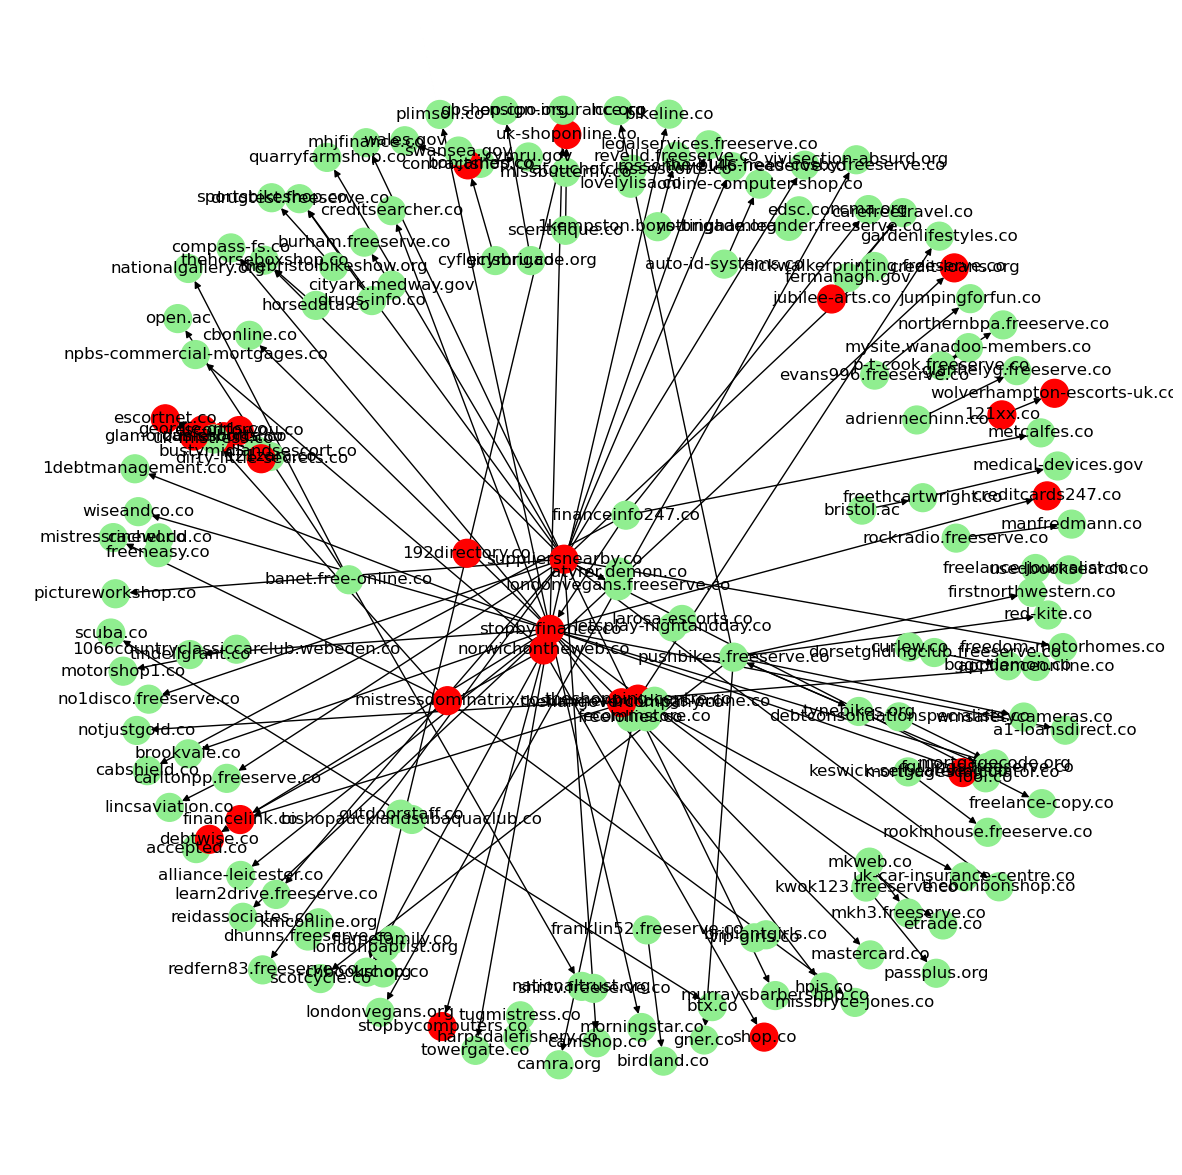

In [7]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if hosts[name2id[hostname]]['label'] == 'spam':
        colors.append('red')
    elif hosts[name2id[hostname]]['label'] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')

    # Shorten the hostnames to generate labels
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label

# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(15, 15))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

<font size="+1" color="red">Replace this cell with a brief commentary on what you see in the plot above.</font>

Let's use this example as a brief exercise to cement the theory, in particular the difference between conditional and joint probabilities and how these apply to edges on a network.

You should calculate the following probabilities (keep in mind edges are directed):
* The (marginal) probability of observing and edge A->B where A is a spam node.
* The (joint) probability of observing a spam->nonspam edge in the network.
* The (conditional) probability of observing a spam->nonspam edge, *given that* we start from a spam node.

Write some code to calculate these probabilities. It should take no more than a few lines of code. Think simple!

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to calculate the probabilities described above. Then briefly comment, do these values make sense to you?</font>

# 2. Compute the degree of each node

Compute the **out-degree** of each node and store it in a dictionary `id2degree`. (Remember we need this for the PageRank algorithm.) 

Do this while reading the edges file, without storing the graph in main memory. Remember that this file contains ``source``, ``destination``, ``weight`` records.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [10]:
# Leave this code as-is

# Initialize id2degree dict
id2degree = {}
N = len(hosts)
for nodeid in range(N):
    id2degree[nodeid] = 0

<font size="+1" color="red">Replace this cell with your code to read the degrees of nodes into `id2degree`.</font>

Verify that you are reading correctly the file. The following cell should print:

```plain
www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38
```

If you get a key not found error, most likely you did not convert the ids to integers or you did not initialize the id2degree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [12]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: degree {id2degree[nodeid]}")

www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38


# 3. Compute PageRank

Perform `ITERATIONS=25` iterations with `ALPHA=0.91`. In each iteration, you will read the file of the graph, **without loading the entire graph in memory**. This means each iteration involves opening (and implicitly, closing) the edges file.

Your code should do the following:

* At the beginning, initialize the vector `pagerank` as a vector of 1/N and the vector `pagerank_aux` as a vector of 0s.
* For `iterations` iterations:
   * Read the graph and for every link from *source* to *destination*:
      * Add to `pagerank_aux[destination]` the value `pagerank[source]/degree`, where `degree` is the out-degree of the source node (i.e, its number of out-links).
   * Set `pagerank` of every node to `alpha x pagerank_aux + (1.0-alpha) x (1.0/N)`.
   * Normalize the values of `pagerank` so they add up to 1.0
   * Compute and print `delta` as the sumation of the absolute changes in PageRank between this iteration and the previous one; this value should decrease from one iteration to the next
   * Set `pagerank_aux` to 0.0

Remember: do not keep the graph in memory, because that will limit the size of the graphs your code can handle. At every iteration you must read the file again. You can use the following template:

```python
for iteration in range(ITERATIONS):
    print(f"Iteration {iteration+1} of {ITERATIONS}")
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        ...

```

After each iteration, print the `delta` with 4 decimals. This sum should be, in general, decreasing.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [13]:
# Leave this cell as-is

ITERATIONS = 25
ALPHA = 0.91

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

<font size="+1" color="red">Replace this cell with your code to compute PageRank.</font>

# 4. Nodes with largest values of PageRank

Print the top 20 hosts by PageRank, including the host name, and the PageRank value with 6 decimals.

You can use the `enumerate()` function which converts a list `[a, b, c]` into `[(0,a), (1,b), (2,c)]` and then `sort()` as follows. Suppose ``score`` contains ``[0.2, 0.7, 0.4]``:

```python
hosts_by_score = sorted(enumerate(score), key=lambda x: x[1], reverse=True)
```

Will return the list `[(1,0.7), (2,0.4), (0,0.2)]`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to print the 20 hosts having the largest PageRank. Print the host `name`, `label`, and score with 6 decimals. Write a function because we will need to do this again.</font>

<font size="+1" color="red">
Replace this cell with a brief commentary indicating: 

1. Why do you think the top sites are those ones; and
2. What is the percentage of commercial, government, and educational sites you see among the top 20?

</font>

# 5. Run non-spam PageRank

Now, write code and run non-spam PageRank. For this, simply ignore any link in which the source and the destination are known spam hosts.

You can query this with something like

```python
hosts[source]['label'] != "spam" and hosts[destination]['label'] != "spam"
```

For this, you first need to compute the "no-spam degree" of the nodes in a dictionary `id2nsdegree` ("ns" stands for **n**on-**s**pam), and use that in the PageRank algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to compute `id2nsdegree`.</font>

Verify that you are reading correctly the file. The following cell should print:

```plain
www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [18]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: normal degree {id2degree[nodeid]} nospam degree {id2nsdegree[nodeid]}")

www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37


<font size="+1" color="red">Replace this cell with code to compute `nspagerank` (non-spam PageRank).</font>

<font size="+1" color="red">Replace this cell with code to print the 20 hosts having the largest no-spam PageRank scores. Print the host `name`, `label`, and score with 6 decimals.</font>

<font size="+1" color="red">Replace this cell with a brief commentary indicating if you see any differences between the non-spam PageRank scores of these hosts and their regular PageRank scores.</font>

# 6. Compute spam gain

Finally, compute the gain of every host as *(Normal PageRank) / (No spam PageRank)*.

Among the top 50 hosts you might find many "spam" (business that look ilegitimate or that tend to rely on spam such as gambling, pornography, counterfeits, and scams). You might also find "normal" sites (i.e., websites that look legitimate), because spammers also point to legitimate sites to disguise their actions.

For each of the top 50 hosts, print the following:

* The hostname
* Its label (spam/nonspam)
* Their gain *(Normal PageRank) / (No spam PageRank)* with two decimals (e.g., "3.22")
* Their PageRank in scientific notation with two significant digits (e.g., "5.8e-06")
* Their no-spam-PageRank in scientific notation with two significant digits (e.g., "5.8e-06")

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the top 50 hosts by spam gain.</font>

<font size="+1" color="red">Replace this cell with a brief explanation, in your own words, of what the spam gain means, what kind of websites have the most spam gain, and what are the effects of using non-spam PageRank.</font>

# Deliver (individually)

A `.zip` file containing:

* This notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>